In [1]:
from torch_geometric.explain import Explainer, AttentionExplainer, GNNExplainer, unfaithfulness
from cell_dataset import loadDataset

from genericpath import exists

from cell_model import Gatv2Predictor

import torch

import networkx as nx
import torch_geometric
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
load_all =  True #load directly from a pickle
pre_separated = False #if three subfolders already exist for train test and val

override = False #make this true to always use the same ones

extension = "_open_lt_lv"
number_of_messages = 2
size_of_messages = 64
absolute = 0
distrib = "normal"
aggr = "mean"

name_complete = extension + "_" + str(number_of_messages) + "_" + str(size_of_messages) + "_" + ("absolute" if absolute else "relative") + "_" + distrib + "_" + aggr

print(name_complete)

model_path = "models/out_8_eps_-2/" + distrib + "/" + extension[6:] + "/model" + name_complete

print(model_path)

data_train, data_test, data_val = loadDataset(load_all, extension, pre_separated, override)

_open_lt_lv_2_64_relative_normal_mean
models/out_4_eps_-2/normal/lt_lv/model_open_lt_lv_2_64_relative_normal_mean
Validation data not found


In [3]:
epoch_to_load = 100

model = Gatv2Predictor(in_channels=12, out_channels=8, hidden_channels=size_of_messages, dropout=0.05, edge_dim=2, messages=number_of_messages, wrap=data_train.wrap, absolute=absolute)

if exists(model_path + str(epoch_to_load) + ".pt") :
    model.load_state_dict(torch.load(model_path + str(epoch_to_load) + ".pt"))
    print("Loaded model")

Loaded model


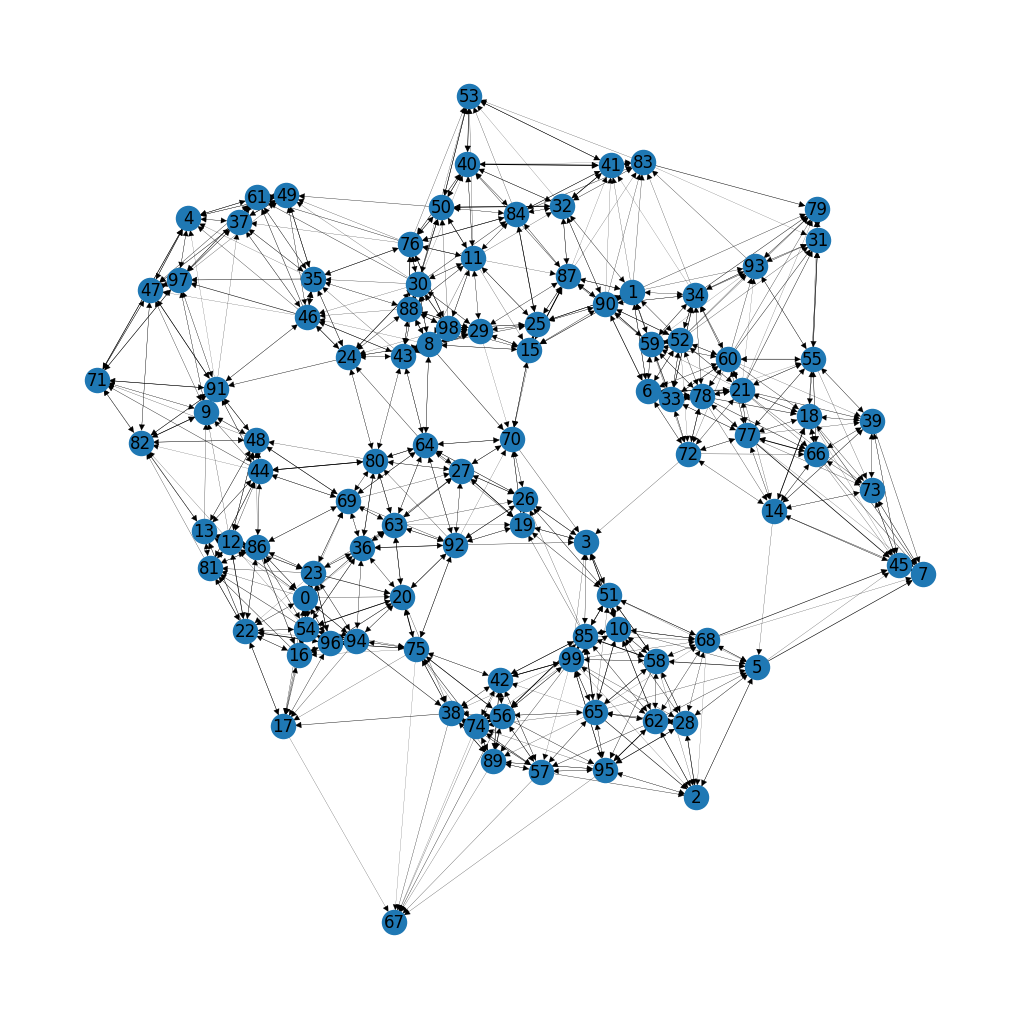

In [4]:
explainer = Explainer(
    model=model,
    algorithm=AttentionExplainer(),
    explanation_type='model',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='edge',
        return_type='raw',
    ),
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
explainer.algorithm = explainer.algorithm.to(device)

x, edge_index, edge_attr, border, params = data_test.get(0)

xshape = x.shape

edge_index = edge_index.to(device)
edge_attr = edge_attr.to(device)
params = params.to(device)
x = x.to(device)

figure = plt.figure(figsize=(10, 10))

def animationFunction(i):
    #clear the figure
    plt.clf()
    
    end = i + 2
    start = end - 1

    mask = torch.logical_and(torch.div(edge_index[0, :], xshape[1], rounding_mode='floor') >= start, \
                        torch.div(edge_index[0, :], xshape[1], rounding_mode='floor') < end)

    edge_index_i = (edge_index[:, mask] - xshape[1] * start)

    kwargs= {"x" : x[start:end][0], "edge_index":edge_index_i, "edge_attr": edge_attr[mask], "params":params}

    # Generate the explanation for a particular graph:
    explanation = explainer(x=kwargs["x"], edge_index=kwargs["edge_index"], edge_attr=kwargs["edge_attr"], params=kwargs["params"])
    
    explanation.validate()

    exp = explanation.get_explanation_subgraph()
    
    g = torch_geometric.utils.to_networkx(exp, to_undirected=False, remove_self_loops=True)

    #draw the edges with the edge mask as the width
    widths = explanation.edge_mask.cpu().numpy()
    pos = exp.x[:,:2].cpu().numpy()

    nx.draw(g, pos=pos, with_labels=True, width=widths)
    
    return figure,

anim = FuncAnimation(figure, animationFunction, frames=xshape[0] - 2, interval=100, blit=True)

anim.save("attention_animation" + name_complete + ".mp4", writer="ffmpeg")
    

In [5]:
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw',
    ),
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
explainer.algorithm = explainer.algorithm.to(device)

x, edge_index, edge_attr, border, params = data_test.get(0)

xshape = x.shape

edge_index = edge_index.to(device)
edge_attr = edge_attr.to(device)
params = params.to(device)
x = x.to(device)

i = 50
    
end = i + 2
start = end - 1

mask = torch.logical_and(torch.div(edge_index[0, :], xshape[1], rounding_mode='floor') >= start, \
                    torch.div(edge_index[0, :], xshape[1], rounding_mode='floor') < end)

edge_index_i = (edge_index[:, mask] - xshape[1] * start)

kwargs= {"x" : x[start:end][0], "edge_index":edge_index_i, "edge_attr": edge_attr[mask], "params":params}

# Generate the explanation for a particular graph:
explanation = explainer(x=kwargs["x"], edge_index=kwargs["edge_index"], edge_attr=kwargs["edge_attr"], params=kwargs["params"])

explanation.validate()

explanation.visualize_feature_importance(path="node_explanation_" + str(start) + name_complete + ".png", feat_labels=["x", "y", "dx", "dy", "degree"])